In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, FunctionTransformer, Imputer
from sklearn.metrics import mean_squared_error

In [2]:
from scipy.stats import skew, kurtosis

In [3]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

In [21]:
read_df = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

## EDA

#### Remove outliers

In [22]:
read_df[['SalePrice', 'GrLivArea', 'OverallQual']].sort_values('GrLivArea', ascending=False).head(3)

,SalePrice,GrLivArea,OverallQual
1298,160000,5642,10
523,184750,4676,10
1182,745000,4476,10


In [6]:
read_df.drop([1298, 523], inplace=True)

In [23]:
read_df.groupby(['Neighborhood'])[['SalePrice']].agg(['count','median','mean', 'min', 'max']).sort_values(
    ('SalePrice','median'), ascending=False)

SalePrice                                       
                 count  median           mean     min     max
Neighborhood                                                 
NridgHt             77  315000  316270.623377  154000  611657
NoRidge             41  301500  335295.317073  190000  755000
StoneBr             25  278000  310499.000000  170000  556581
Timber              38  228475  242247.447368  137500  378500
Somerst             86  225500  225379.837209  144152  423000
Veenker             11  218000  238772.727273  162500  385000
Crawfor             51  200624  210624.725490   90350  392500
ClearCr             28  200250  212565.428571  130000  328000
CollgCr            150  197200  197965.773333  110000  424870
Blmngtn             17  191000  194870.882353  159895  264561
NWAmes              73  182900  189050.068493   82500  299800
Gilbert             79  181000  192854.506329  141000  377500
SawyerW             59  179900  186555.796610   76000  320000
Mitchel             49  153500  156270.122449   84500  271000
NPkVill              9  146000  142694.444444  127500  155000
NAmes              225  140000  145847.080000   87500  345000
SWISU               25  139500  142591.360000   60000  200000
Blueste              2  137500  137500.000000  124000  151000
Sawyer              74  135000  136793.135135   62383  190000
BrkSide             58  124300  124834.051724   39300  223500
Edwards            100  121750  128219.700000   58500  320000
OldTown            113  119000  128225.300885   37900  475000
BrDale              16  106000  104493.750000   83000  125000
IDOTRR              37  103000  100123.783784   34900  169500
MeadowV             17   88000   98576.470588   75000  151400

In [8]:
read_df.groupby(['Neighborhood', 'MSZoning',  'MSSubClass'])[['SalePrice']].agg(['count','median','mean', 'min', 'max']).sort_values(
    ('SalePrice','median'), ascending=False)

SalePrice                                   \
                                     count    median           mean     min   
Neighborhood MSZoning MSSubClass                                              
StoneBr      RL       60                 5  438780.0  444056.000000  325000   
                      20                 7  377426.0  373885.000000  260000   
NoRidge      RL       50                 2  347500.0  347500.000000  285000   
NridgHt      RL       60                23  342643.0  361124.565217  275000   
NoRidge      RL       20                 6  325750.0  345066.666667  260400   
NridgHt      RL       20                32  325500.0  344804.781250  214000   
SawyerW      RL       50                 1  316600.0  316600.000000  316600   
Veenker      RL       60                 1  294000.0  294000.000000  294000   
NoRidge      RL       60                33  290000.0  332779.030303  190000   
SawyerW      RL       80                 1  275000.0  275000.000000  275000   
Crawfor      RM       120                3  275000.0  300833.333333  235000   
Veenker      RL       120                3  270000.0  279833.333333  245500   
ClearCr      RL       40                 1  260000.0  260000.000000  260000   
Somerst      FV       60                25  250000.0  248558.600000  186500   
Timber       RL       60                 9  250000.0  254112.555556  202900   
Somerst      RL       20                19  248328.0  263408.000000  147000   
ClearCr      RL       70                 1  244400.0  244400.000000  244400   
Timber       RL       20                24  243950.0  248830.833333  137500   
ClearCr      RL       20                 8  238250.0  229687.500000  143000   
NAmes        RL       75                 1  235000.0  235000.000000  235000   
Somerst      RL       60                 2  233500.0  233500.000000  214000   
NWAmes       RL       50                 1  229000.0  229000.000000  229000   
Timber       RL       190                1  228950.0  228950.000000  228950   
StoneBr      RL       160                2  223250.0  223250.000000  207500   
Crawfor      RL       20                11  223000.0  234011.272727  158500   
Somerst      FV       20                13  222000.0  226289.538462  176000   
SawyerW      RL       60                23  220000.0  222203.478261  171000   
NridgHt      RL       120               18  216750.0  239095.555556  171750   
BrkSide      RL       75                 1  214500.0  214500.000000  214500   
StoneBr      RL       120               11  213500.0  225318.181818  170000   
...                                    ...       ...            ...     ...   
IDOTRR       RM       45                 2  113200.0  113200.000000   87000   
OldTown      RL       50                 6  110500.0  122666.666667  105000   
IDOTRR       RM       90                 1  110000.0  110000.000000  110000   
Sawyer       RL       30                 2  110000.0  110000.000000  108000   
OldTown      RL       30                 5  108480.0   97696.000000   64500   
SawyerW      RH       20                 3  107000.0  102966.666667   82000   
IDOTRR       RM       30                 9  106500.0   99088.888889   55000   
OldTown      RL       190                3  106250.0  120416.666667   95000   
BrDale       RM       160               16  106000.0  104493.750000   83000   
OldTown      RM       30                17  105900.0  101715.941176   52500   
Edwards      RH       70                 1  103600.0  103600.000000  103600   
OldTown      RL       45                 1  103200.0  103200.000000  103200   
IDOTRR       RM       75                 1  101000.0  101000.000000  101000   
Crawfor      RL       45                 1   96500.0   96500.000000   96500   
IDOTRR       C (all)  50                 4   93888.0   91044.000000   68400   
MeadowV      RM       160                8   92500.0  102737.500000   75000   
BrkSide      RM       30                 7   89000.0   87500.000000   60000   
OldT

### Looking for Interactions
Look for variables that have different slopes for different levels of the variable. See the neighborhood example below - compare 'Crawford' to 'NoRidge' - the slopes are different. 

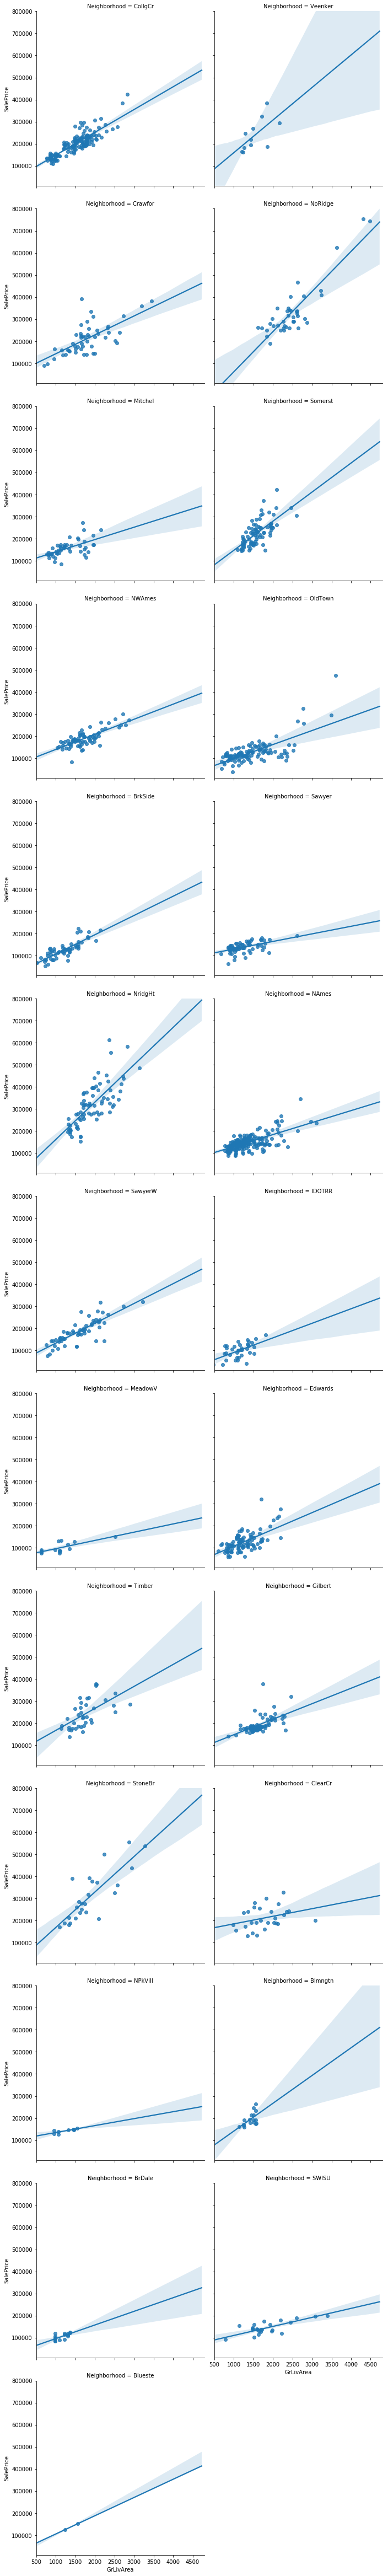

In [9]:
g = sns.lmplot(x="GrLivArea", y="SalePrice", col="Neighborhood",
           sharex = True, sharey = True, logx=False, data=read_df, 
          col_wrap=2)
g.set(xlim=(500, 4800), ylim=(10000, 800000))
plt.show()

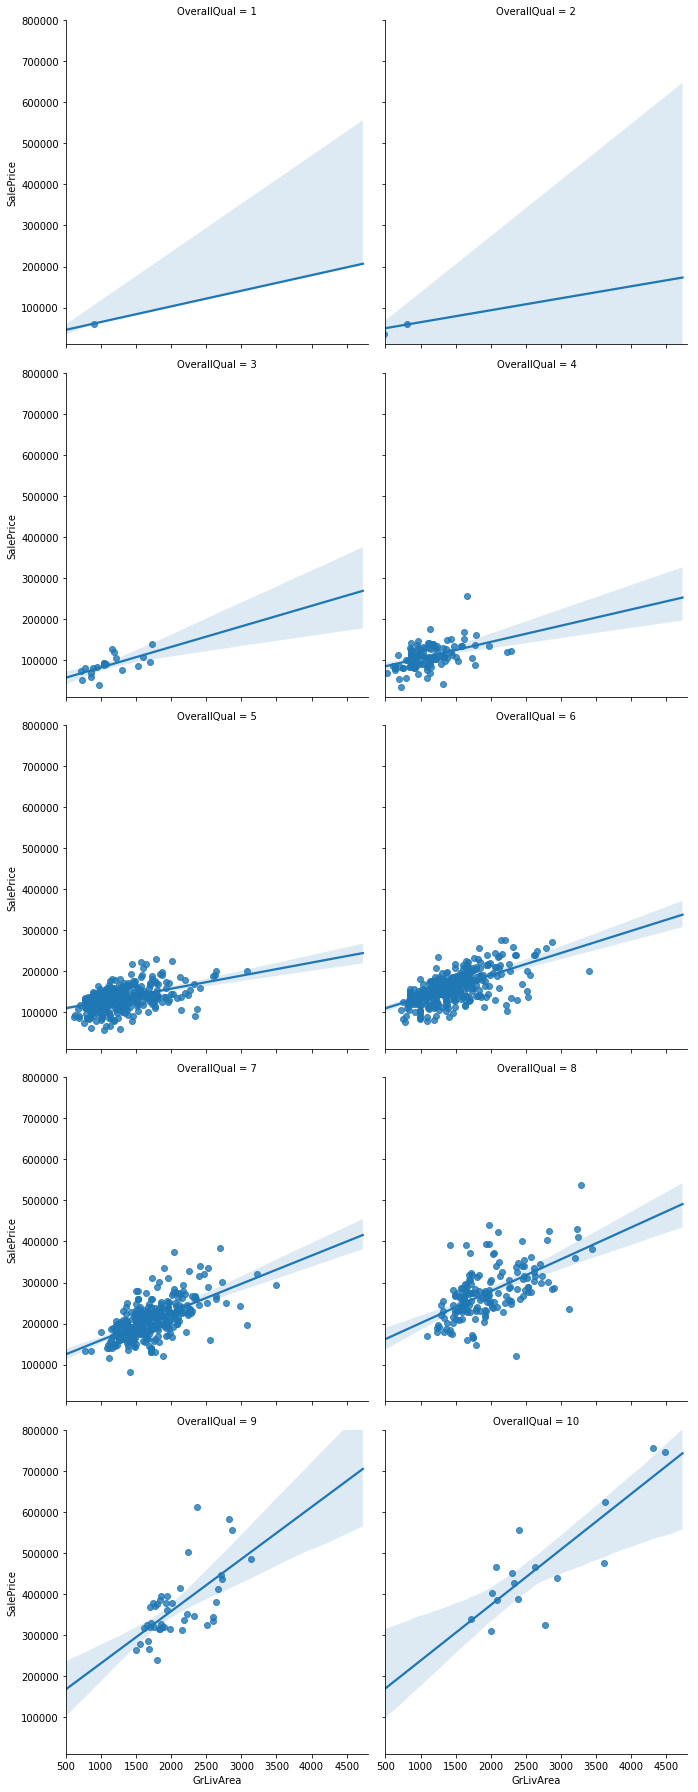

In [10]:
g = sns.lmplot(x="GrLivArea", y="SalePrice", col="OverallQual",
           sharex = True, sharey = True, logx=False, data=read_df, 
          col_wrap=2)
g.set(xlim=(500, 4800), ylim=(10000, 800000))
plt.show()


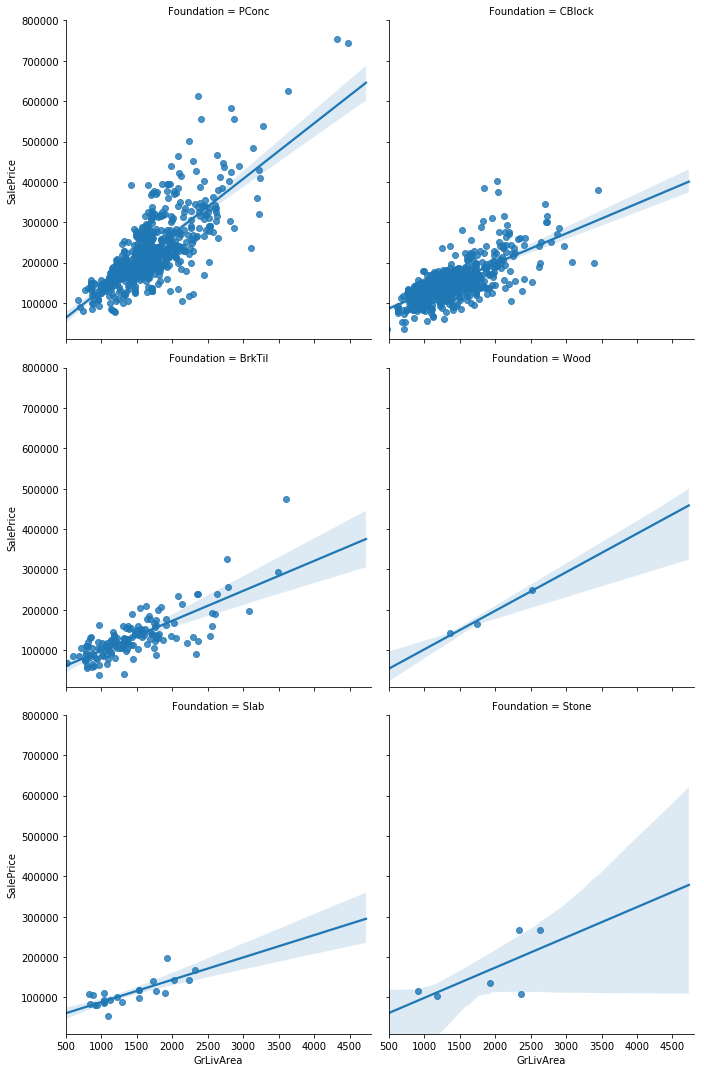

In [11]:
g = sns.lmplot(x="GrLivArea", y="SalePrice", col="Foundation",
           sharex = True, sharey = True, logx=False, data=read_df, 
          col_wrap=2);
g.set(xlim=(500, 4800), ylim=(10000, 800000))
plt.show()


### Add new features to read_df and test_data

In [31]:
read_df['Age'] = np.max(read_df[['YrSold', 'YearRemodAdd']], axis = 1) - read_df['YearRemodAdd'] + 1
test_data['Age'] = np.max(read_df[['YrSold', 'YearRemodAdd']], axis = 1) - test_data['YearRemodAdd'] + 1

In [32]:
#%matplotlib inline

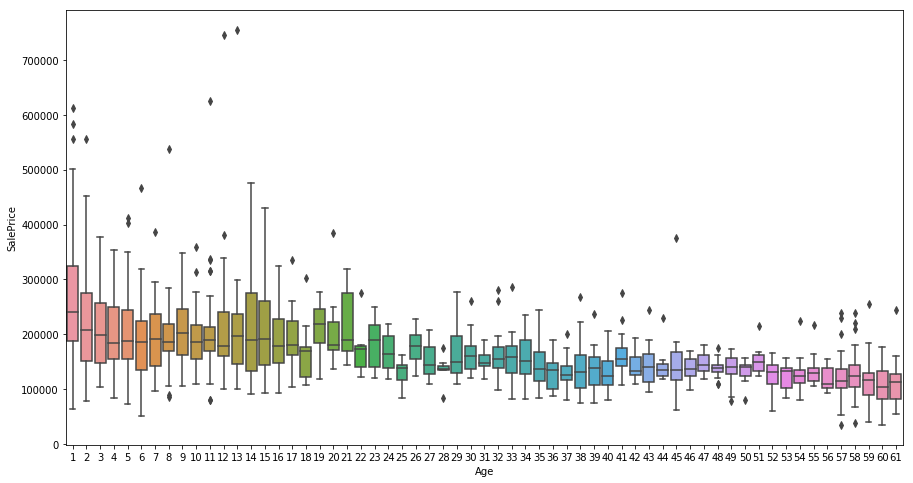

In [33]:
plt.figure(figsize=(15,8))
sns.boxplot(read_df.Age, read_df.SalePrice)
plt.show()

#### Identify columns, assign to lists so that they can be processed separetely when needed

In [34]:
to_string_cols = ['MSSubClass','GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 
              'YrSold', 'MoSold' ]
read_df[to_string_cols] = read_df[to_string_cols].astype('str')
test_data[to_string_cols] = test_data[to_string_cols].astype('str')

numeric_cols = read_df.dtypes[(read_df.dtypes == 'int64') | (read_df.dtypes == 'float64')].index.tolist()
exclude_numeric_cols = ['Id', 'SalePrice']
numeric_cols = [x for x in numeric_cols if x not in exclude_numeric_cols]

cat_cols = read_df.dtypes[read_df.dtypes =='object'].index.tolist()

exclude_cat_cols = ['Alley', 'Condition2']


cat_cols = [x for x in cat_cols if x not in exclude_cat_cols]
area_cols = [x for x in numeric_cols if re.search(r'Area|SF|Porch', x)]

#### Give datasets common categories for categorical columns

In [35]:
def set_combined_categories(df1, df2):
    df = df1.copy()
    try: 
        cols = df1.columns
    except:
        cols = df1.name
    for col in cols:
        col_categories = np.union1d(df1[col].astype('category').cat.categories, 
                                    df2[col].astype('category').cat.categories)
        df[col] = df1[col].astype('category').cat.set_categories(col_categories)
    return df

In [36]:
read_df[cat_cols] = set_combined_categories(read_df[cat_cols], test_data)
test_data[cat_cols] = set_combined_categories(test_data[cat_cols], read_df)

Remove unused categories from training data so that they don't become dummy-coded columns

In [37]:
for col in cat_cols: 
    read_df[col].cat.remove_unused_categories(inplace=True)

Fill NAs for numerics and a couple categoricals

In [38]:
def fix_nas(df):
    fill_with_zero = ['MasVnrArea', 'LotFrontage']
    test_fill_with_zero = ['BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtFinSF1',
                'GarageCars', 'BsmtUnfSF', 'BsmtFinSF2', 'GarageArea' ]
    fill_na_cols = fill_with_zero + test_fill_with_zero
    df[fill_na_cols] =  df[fill_na_cols].fillna(0)
    df.loc[df.Electrical.isnull(), 'Electrical'] = 'SBrkr'
    df.loc[df.MasVnrType.isnull(), 'MasVnrType'] = 'None'
    return df


In [39]:
read_df = fix_nas(read_df)
test_data = fix_nas(test_data)

#### Categoricals with missing values (currently left as is)

In [40]:
test_data[cat_cols].isnull().sum().to_frame('Test Nulls').sort_values(
    'Test Nulls', ascending=False).head(20).join(
(read_df[cat_cols].isnull().sum().to_frame('Train Nulls').sort_values(
    'Train Nulls', ascending=False).head(13)), how='outer').fillna(0)

,Test Nulls,Train Nulls
BsmtCond,45,37.0
BsmtExposure,44,38.0
BsmtFinType1,42,37.0
BsmtFinType2,42,38.0
BsmtQual,44,37.0
Exterior1st,1,0.0
Exterior2nd,1,0.0
Fence,1169,1179.0
FireplaceQu,730,690.0
Functional,2,0.0


Check for numeric nulls in both data sets

In [41]:
print(np.sum(read_df[numeric_cols].any().isnull()))
print(np.sum(test_data[numeric_cols].any().isnull()))

0
0


#### Varialbes to hold lists of columns to use

In [42]:
continuous_vars = [x for x in numeric_cols if x not in area_cols]
area_vars = area_cols

#### Pairs of variables from which to calculate interaction variables

In [43]:
int_pairs = [('GrLivArea', 'Neighborhood'), 
             ('GrLivArea', 'Functional'), 
             ('GrLivArea', 'OverallQual')]

#### Functions to use outside of pipeline

In [44]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')
get_X_area = lambda x:x[area_vars]
get_X_cont = lambda x:x[continuous_vars]
get_X_cat = lambda x: pd.get_dummies(x[cat_cols]).apply(categorize_label)

get_X = lambda x: get_X_cont(x).join(get_X_area(x)).join(get_X_cat(x))

#### Create X from entire training set, X_submit from test data

In [45]:
X = get_X(read_df)
X_submit = get_X(test_data)

The test data has more columns because it has some levels of categorical variables that aren't present in the train dataset (see below)

In [46]:
print(X.shape)
print(X_submit.shape)

(1460, 576)
(1459, 589)


In [47]:
[col for col in X_submit.columns if col not in X.columns]

['MSSubClass_150',
 'YearBuilt_1879',
 'YearBuilt_1895',
 'YearBuilt_1896',
 'YearBuilt_1901',
 'YearBuilt_1902',
 'YearBuilt_1907',
 'GarageYrBlt_1895.0',
 'GarageYrBlt_1896.0',
 'GarageYrBlt_1917.0',
 'GarageYrBlt_1919.0',
 'GarageYrBlt_1943.0',
 'GarageYrBlt_2207.0']

Now that dummy variables have been created, we can define cat_vars.

In [48]:
cat_vars = [x for x in X.columns if x not in area_vars + continuous_vars]

#### Assign y

In [49]:
y = read_df['SalePrice']
y_log = read_df['SalePrice'].apply(np.log)

#### Functions to turn object columns into categories and then select/transform variables in pipeline

In [50]:
def get_categorical_datagorical_data_func(x):
    df = x[cat_vars]
    return df
def get_continuous_data_func(x):
    df = x[continuous_vars]
    return df
def get_area_data_func(x):
    df = x[area_vars]
    return df
def log_scaler_func(x):
    scaled = np.log1p(x)
    return scaled 

In [51]:
def get_interaction_vars_func(x, col_pairs=int_pairs):
    base_cols = []
    # Create list of columns from tuples
    [base_cols.extend(list(tup)) for tup in col_pairs]
    # Get list of unique columns used to generate interaction variables
    base_cols = list(set(base_cols))
    x_cols = x.columns
    df = x.copy()
    for pair in col_pairs:
        scaler_0 = lambda x: x 
        scaler_1 = lambda x: x 
        if pair[0] in area_vars:
            scaler_0 = lambda x: np.log1p(x)
        if pair[1] in area_vars:
            scaler_1 = lambda x: np.log1p(x)
        vals_0 = lambda x: x
        vals_1 = lambda x: x
        if pair[0] in cat_cols:
            vals_0 = lambda x: x.astype('int')
        if pair[1] in cat_cols:
            vals_1 = lambda x: x.astype('float')
        cols_first = x_cols[x_cols.str.startswith(pair[0])]
        cols_second = x_cols[x_cols.str.startswith(pair[1])]
        for col_first in cols_first:
            for col_second in cols_second:
                col_name = col_first + '_by_' + col_second
                df[col_name] = scaler_0(vals_0(x[col_first])) * scaler_1(vals_1(x[col_second]))
    keep_cols = [col for col in df.columns if col not in x_cols]
    df = df[keep_cols]
    return df   

Test `get_interaction_vars_func` (scroll right in results)

In [52]:
get_interaction_vars_func(X.head())

,GrLivArea_by_Neighborhood_Blmngtn,GrLivArea_by_Neighborhood_Blueste,GrLivArea_by_Neighborhood_BrDale,GrLivArea_by_Neighborhood_BrkSide,GrLivArea_by_Neighborhood_ClearCr,GrLivArea_by_Neighborhood_CollgCr,GrLivArea_by_Neighborhood_Crawfor,GrLivArea_by_Neighborhood_Edwards,GrLivArea_by_Neighborhood_Gilbert,GrLivArea_by_Neighborhood_IDOTRR,...,GrLivArea_by_Neighborhood_Timber,GrLivArea_by_Neighborhood_Veenker,GrLivArea_by_Functional_Maj1,GrLivArea_by_Functional_Maj2,GrLivArea_by_Functional_Min1,GrLivArea_by_Functional_Min2,GrLivArea_by_Functional_Mod,GrLivArea_by_Functional_Sev,GrLivArea_by_Functional_Typ,GrLivArea_by_OverallQual
0,0.0,0.0,0.0,0.0,0.0,7.444833,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.444833,52.113833
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,7.141245,0.0,0.0,0.0,0.0,0.0,0.0,7.141245,42.847471
2,0.0,0.0,0.0,0.0,0.0,7.488294,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.488294,52.418055
3,0.0,0.0,0.0,0.0,0.0,0.000000,7.448916,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.448916,52.142413
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.695758,61.566064


#### Create transformer functions that can be used in pipelines. 

In [53]:
# Create transformer functions that can be used in pipelines. 
get_categorical_data = FunctionTransformer(get_categorical_datagorical_data_func, validate=False)
get_continuous_data = FunctionTransformer(get_continuous_data_func, validate=False)
get_area_data = FunctionTransformer(get_area_data_func, validate=False)
get_interction_features = FunctionTransformer(get_interaction_vars_func, validate=False)

# Custom scaler for area columns; uses log(x + 1)
log_scaler = FunctionTransformer(log_scaler_func, validate=False)

#### Make pipelines for each type of feature. 
Each feature type needs different treatment. Some just need to be selected, some need to be log scaled (area features), and some need to be created in the pipeline (interaction variables).

In [54]:
categorical = Pipeline([
        ('selector', get_categorical_data)
    ])
coninuous = Pipeline([
        ('selector', get_continuous_data),
        ('imputer', Imputer())
    ])
area = Pipeline([
        ('selector', get_area_data), 
        ('log_scaler', log_scaler)
    ])
interact = Pipeline([
        ('selector', get_interction_features)
    ])

feats = FeatureUnion([('categorical', categorical), 
                      ('coninuous', coninuous), 
                      ('area', area), 
                      ('interact', interact)])

#Turn the FeatureUnion into a pipeline
feats_pipe = Pipeline([('feats', feats), 
                      ('robust_scaler', RobustScaler())])
feats_pipe.fit_transform(X)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.38347985,  0.50678095],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.22376946, -0.05166861],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.47041079,  0.52511527],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.01055563,  0.63903547],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.53871764, -0.5294914 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.23329443, -0.4834801 ]])

Function to cross-validate models

In [55]:
def cv_rmse(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    cv_dict = {}
    cvs = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    cv_dict['cv_mean'] = np.mean(cvs)
    cv_dict['cvs'] = cvs
    return cv_dict

Create a dictionary to store the best parameters found from each model

In [56]:
model_params_dict = {}
model_cvs = {}

Model pipelines (treat like model objects)

In [57]:
# Elastic Net
en_pl = Pipeline([
    ('features', feats_pipe), 
    ('en', ElasticNet(max_iter=10000))
])

# Lasso Regression 
lasso_pl = Pipeline([
    ('features', feats_pipe), 
    ('lasso', Lasso(max_iter=15000))
])


# Ridge Regression 
ridge_pl = Pipeline([
    ('features', feats_pipe), 
    ('ridge', Ridge(max_iter=15000))
])

### Elastic Net Regression
 - best params: `{'en__alpha': 0.001, 'en__l1_ratio': 0.75, 'en__Normalize' : False}`
 - best CV score: 0.1112624583938123
     - best submission score: `0.12289`

In [58]:
l1_space = [ .5, .75, .90, .95, .98, .99]
en_params = {'en__l1_ratio': l1_space, 
            'en__alpha': [0.003, 0.002, 0.001, 0.0005, 0.0003], 
            'features__robust_scaler' : [None, RobustScaler(with_centering=False)]}
en_gs = GridSearchCV(en_pl, en_params, cv = 3)
en_gs.fit(X, y_log)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'en__l1_ratio': [0.5, 0.75, 0.9, 0.95, 0.98, 0.99], 'en__alpha': [0.003, 0.002, 0.001, 0.0005, 0.0003], 'features__robust_scaler': [None, RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['en'] = en_gs.best_params_
en_gs.best_params_

{'en__alpha': 0.0005,
 'en__l1_ratio': 0.99,
 'features__robust_scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
        with_scaling=True)}

Set the model params using the dictionary. The `**` unpacks the dictionary into the key-value pairs - essentially, it removes the curly braces.

In [60]:
en_pl.set_params(**model_params_dict['en'])
en_pl.fit(X, y_log)

Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [63]:
from pprint import pprint

Get and print model cross validation scores:

In [64]:
model_cvs['en'] = cv_rmse(en_pl, X, y_log)
pprint(model_cvs['en'])

{'cv_mean': 0.1213448013336246,
 'cvs': array([ 0.10328025,  0.13020762,  0.12437797,  0.10848884,  0.14036934])}


### Lasso Regression
 - Best hyperparameters: `{'lasso__alpha': 0.001}`
 - Best CV score: `0.11163718018313713`
 - Maybe from Lasso, outliers excluded: `0.12017615301776012`
 - CV with outliers included and `RobustScaler()`: `0.12490777027682327`
 - CV with outliers EXCLUDED : `0.11225806314356161`
 - CV with outliers EXCLUDED and `RobustScaler()`: `0.1116387850305959`

In [65]:
lasso_params = {'lasso__alpha': [.001, .0005, .0004, .0003, .0002, .0001], 
               'features__robust_scaler' : [None, RobustScaler(with_centering=False)]}
lasso_gs = GridSearchCV(lasso_pl, lasso_params, cv = 3, scoring='neg_mean_squared_error')
lasso_gs.fit(X, y_log)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': [0.001, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001], 'features__robust_scaler': [None, RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [66]:
pd.DataFrame(lasso_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__robust_scaler,param_lasso__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.304811,0.159758,-0.015505,-0.011417,None,0.001,"{'features__robust_scaler': None, 'lasso__alph...",6,-0.012225,-0.012568,-0.018076,-0.010304,-0.016216,-0.011379,0.015619,0.021804,0.002442,0.000925
1,1.165098,0.144384,-0.015270,-0.009473,None,0.0005,"{'features__robust_scaler': None, 'lasso__alph...",2,-0.011938,-0.010296,-0.017713,-0.008187,-0.016159,-0.009935,1.107445,0.001418,0.002441,0.000921
2,1.853930,0.231630,-0.015459,-0.008955,None,0.0004,"{'features__robust_scaler': None, 'lasso__alph...",5,-0.012098,-0.009752,-0.017864,-0.007647,-0.016415,-0.009466,1.844888,0.033754,0.002450,0.000932
3,1.810815,0.160426,-0.015831,-0.008317,None,0.0003,"{'features__robust_scaler': None, 'lasso__alph...",8,-0.012426,-0.009084,-0.018212,-0.007020,-0.016857,-0.008847,1.680545,0.021285,0.002471,0.000922
4,2.346907,0.195186,-0.016567,-0.007479,None,0.0002,"{'features__robust_scaler': None, 'lasso__alph...",10,-0.013033,-0.008208,-0.018944,-0.006180,-0.017727,-0.008050,1.508953,0.035613,0.002549,0.000921
5,4.184793,0.174130,-0.018420,-0.006236,None,0.0001,"{'features__robust_scaler': None, 'lasso__alph...",12,-0.014799,-0.006789,-0.021063,-0.005004,-0.019402,-0.006915,1.317942,0.019654,0.002650,0.000873
6,0.407418,0.148059,-0.015383,-0.011297,"RobustScaler(copy=True, quantile_range=(25.0, ...",0.001,{'features__robust_scaler': RobustScaler(copy=...,4,-0.012018,-0.012429,-0.017963,-0.010172,-0.016171,-0.011289,0.085981,0.003101,0.002491,0.000921
7,0.446856,0.228273,-0.015207,-0.009445,"RobustScaler(copy=True, quantile_range=(25.0, ...",0.0005,{'features__robust_scaler': RobustScaler(copy=...,1,-0.012017,-0.010237,-0.017445,-0.008205,-0.016162,-0.009895,0.091025,0.026202,0.002317,0.000888
8,0.406748,0.172458,-0.015343,-0.008941,"RobustScaler(copy=True, quantile_range=(25.0, ...",0.0004,{'features__robust_scaler': RobustScaler(copy=...,3,-0.012161,-0.009706,-0.017457,-0.007695,-0.016413,-0.009423,0.083235,0.020451,0.002291,0.000889
9,0.402070,0.148728,-0.015675,-0.008317,"RobustScaler(copy=True, quantile_range=(25.0, ...",0.0003,{'features__robust_scaler': RobustScaler(copy=...,7,-0.012501,-0.009053,-0.017720,-0.007069,-0.016806,-0.008827,0.030090,0.003310,0.002276,0.000887


In [67]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lasso'] = lasso_gs.best_params_
lasso_gs.best_params_

{'features__robust_scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
        with_scaling=True), 'lasso__alpha': 0.0005}

In [68]:
lasso_pl.set_params(**model_params_dict['lasso'])
lasso_pl.fit(X, y_log)

Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [69]:
model_cvs['lasso'] = cv_rmse(lasso_pl, X, y_log)
pprint(model_cvs['lasso'])

{'cv_mean': 0.12132691205813151,
 'cvs': array([ 0.10324606,  0.13020292,  0.12435751,  0.10850389,  0.14032418])}


### Ridge Regression
 - Best hyperparameters: `{'ridge__alpha': 50}`
 - Best CV score: `0.11364010845042886`

In [70]:
ridge_params = {'ridge__alpha': [10, 30, 50, 75, 80, 95, 130], 
               'features__robust_scaler' : [None, RobustScaler(with_centering=False)]}
ridge_gs = GridSearchCV(ridge_pl, ridge_params, cv = 3, scoring='neg_mean_squared_error')
ridge_gs.fit(X, y_log)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...t_intercept=True, max_iter=15000,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [10, 30, 50, 75, 80, 95, 130], 'features__robust_scaler': [None, RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [71]:
pd.DataFrame(ridge_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__robust_scaler,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.259859,0.158756,-0.016963,-0.008738,None,10,"{'features__robust_scaler': None, 'ridge__alph...",12,-0.014048,-0.009695,-0.019377,-0.007774,-0.017466,-0.008745,0.014557,0.000945,0.002205,0.000784
1,0.247324,0.155080,-0.016524,-0.010417,None,30,"{'features__robust_scaler': None, 'ridge__alph...",7,-0.013825,-0.011490,-0.018960,-0.009363,-0.016787,-0.010396,0.002633,0.003691,0.002106,0.000868
2,0.246310,0.157419,-0.016626,-0.011344,None,50,"{'features__robust_scaler': None, 'ridge__alph...",8,-0.014112,-0.012460,-0.019011,-0.010239,-0.016757,-0.011334,0.004032,0.002166,0.002003,0.000907
3,0.269049,0.180480,-0.016877,-0.012175,None,75,"{'features__robust_scaler': None, 'ridge__alph...",10,-0.014538,-0.013303,-0.019189,-0.011038,-0.016904,-0.012185,0.035273,0.035685,0.001900,0.000925
4,0.247993,0.157094,-0.016932,-0.012316,None,80,"{'features__robust_scaler': None, 'ridge__alph...",11,-0.014622,-0.013443,-0.019230,-0.011175,-0.016943,-0.012331,0.000473,0.002072,0.001882,0.000926
5,0.241976,0.159090,-0.017096,-0.012704,None,95,"{'features__robust_scaler': None, 'ridge__alph...",13,-0.014865,-0.013826,-0.019356,-0.011554,-0.017068,-0.012732,0.002500,0.001891,0.001834,0.000928
6,0.247982,0.161095,-0.017470,-0.013457,None,130,"{'features__robust_scaler': None, 'ridge__alph...",14,-0.015378,-0.014558,-0.019649,-0.012298,-0.017381,-0.013515,0.003677,0.001251,0.001745,0.000924
7,0.267711,0.160762,-0.016729,-0.008589,"RobustScaler(copy=True, quantile_range=(25.0, ...",10,{'features__robust_scaler': RobustScaler(copy=...,9,-0.013754,-0.009544,-0.018990,-0.007653,-0.017445,-0.008570,0.002457,0.007383,0.002197,0.000772
8,0.269383,0.158421,-0.016035,-0.010069,"RobustScaler(copy=True, quantile_range=(25.0, ...",30,{'features__robust_scaler': RobustScaler(copy=...,5,-0.013179,-0.011157,-0.018381,-0.009072,-0.016546,-0.009978,0.001250,0.001418,0.002155,0.000854
9,0.275065,0.159424,-0.015909,-0.010824,"RobustScaler(copy=True, quantile_range=(25.0, ...",50,{'features__robust_scaler': RobustScaler(copy=...,1,-0.013177,-0.011978,-0.018307,-0.009786,-0.016245,-0.010707,0.005327,0.002166,0.002108,0.000898


In [72]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['ridge'] = ridge_gs.best_params_
ridge_gs.best_params_

{'features__robust_scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
        with_scaling=True), 'ridge__alpha': 50}

In [73]:
ridge_pl.set_params(**model_params_dict['ridge'])
ridge_pl.fit(X, y_log)

Pipeline(memory=None,
     steps=[('features', Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_datagorical_data_func at 0x0000020538955158...t_intercept=True, max_iter=15000,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [74]:
model_cvs['ridge'] = cv_rmse(ridge_pl, X, y_log)
pprint(model_cvs['ridge'])

{'cv_mean': 0.12396538540372473,
 'cvs': array([ 0.10782051,  0.13166207,  0.12606999,  0.11293729,  0.14133707])}


## Prepare data for submission

#### Remove unused columns from Test Features (X_submit)

In [75]:
X_submit = X_submit[X.columns]

Check for any other NAs in test data. Hide cell output by pressing 'o' when the cell is highlighted in blue. 

In [77]:
np.sum(X_submit.any().isnull())

0

In [ ]:
# See which columns have NAs if the above output is greather than 0
#X_submit.isna().sum().to_frame('na_sum').sort_values('na_sum', ascending=False)

In [78]:
ridge_test_preds = np.exp(ridge_pl.predict(X_submit))
lasso_test_preds = np.exp(lasso_pl.predict(X_submit))
en_test_preds = np.exp(en_pl.predict(X_submit))
submission_df = pd.DataFrame(data ={'Id' : test_data.Id, 'SalePrice': en_test_preds}).set_index('Id')

In [79]:
submission_df.head()

,SalePrice
Id,
1461,117704.848848
1462,153974.878625
1463,179777.343723
1464,195105.591105
1465,211519.895670


In [80]:
submission_df.to_csv('en_inter_rscale_wo_outliers.csv')